Author : Muhammad Rafif Dwidayatama (rafifdwida@gmail.com) - Agustus 2023

# Bussiness Understanding

Tim Inventory ingin dibantu untuk memprediksi jumlah penjualan (quantity) dari total keseluruhan produck Kalbe
- mengetahui perkiraan quantity product yang terjual sehingga tim inventory dapat membuat stock persediaan harian yang cukup
- Prediksi yang dilakukan harus **Harian**

Tim Marketing ingin dibantu untuk dibuatkan cluster customer berdasarkan beberapa kriteria 
- Membuat cluster pada customer
- Cluster customer ini nantinya akan digunakan oleh tim marketing untuk memberikan personlized promotion dan sales treatment

# Bussiness Objective

**Pernyataan Masalah :**

Melakukan pengananan promosi dan treatment yang kurang tepat pada cluster customer dapat menyebabkan berkurangnya pembelian dikarenakan customer yang berkurang dan bisa beralih ke merk lainnya.

**Tujuan :**

1. Identifikasi pola cluster berdasarkan seringnya berbelanja, total harga yang sudah dibelanjakan, jumlah beberapa kali belanja, dll. 
2. Menerapkan algoritma machine learning untuk membangin model prediksi sehingga tim inventory dapat mengetahui perkiraan quantity produck dan menyiapkan product di setiap harinya
3. Menerapkan algoritma machine learning untuk membangun model clustering sehingga tim marketing dapat membuat promotions dan sales treatment yang tepat sesuai dengan cluster customer agar customer di setiap cluster dapat meningkat dan terupgrade customer ke cluster berikutnya

# Data Preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from itertools import permutations

warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)

In [4]:
dfc = pd.read_csv ('Case Study - Customer.csv', sep=';')
dfp = pd.read_csv ('Case Study - Product.csv', sep=';')
dfs = pd.read_csv ('Case Study - Store.csv', sep=';')
dft = pd.read_csv ('Case Study - Transaction.csv', sep=';')

# Data Understanding

### Dataset Customer

- `CustomerID` : No Unik Customer
- `Age` : Usia Customer
- `Gender` : 0 Wanita, 1 Pria
- `Marital` Status : Married, Single (Blm menikah/Pernah menikah)
- `Income` : Pendapatan per bulan dalam jutaan rupiah

In [7]:
dfc.shape

(447, 5)

In [36]:
dfc.sample(10)

,CustomerID,Age,Gender,Marital Status,Income
43,44,40,0,Married,"10,65"
331,332,28,1,Single,"6,91"
217,218,29,0,Married,"3,52"
293,294,54,1,Married,"19,07"
260,261,46,0,Single,"5,89"
78,79,20,1,Single,"1,6"
413,414,21,1,Single,"0,74"
127,128,0,1,Married,"6,77"
434,435,29,1,Married,"3,61"
319,320,30,0,Married,"3,72"


#### Preview data tiap kolom

In [10]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


#### Mengubah tipe data pada kolom `income` dari int menjadi float

In [5]:
dfc["Income"] = dfc["Income"].str.replace(",", ".").astype(float)

#### Melihat Ringkasan Singkat

In [11]:
dfc_num = dfc.select_dtypes(include=['int64', 'float64'])
dfc_cat = dfc.select_dtypes(include=['object'])

In [12]:
dfc_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,447.000000,224.000000,129.182042,1.000000,112.500000,224.000000,335.500000,447.000000
Age,447.000000,39.782998,12.848719,0.000000,30.000000,39.000000,50.500000,72.000000
Gender,447.000000,0.458613,0.498842,0.000000,0.000000,0.000000,1.000000,1.000000
Income,447.000000,8.592103,6.607065,0.000000,4.175000,7.520000,10.810000,71.300000


In [8]:
dfc_cat.describe().T

,count,unique,top,freq
Marital Status,444,2,Married,340


### Dataset Product

- `ProductID` : Kode Unik Product
- `Product Name` : Nama Product
- `Price` : Harga dlm rupiah


In [15]:
dfp.shape

(10, 3)

In [26]:
dfp.head(10)

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


In [19]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 372.0+ bytes


In [69]:
dfp_num = dfp.select_dtypes(include=['int64'])
dfp_cat = dfp.select_dtypes(include=['object'])

In [21]:
dfp_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,10.000000,10410.000000,4890.455557,3200.000000,7825.000000,9700.000000,14250.000000,18000.000000


In [22]:
dfp_cat.describe().T

,count,unique,top,freq
ProductID,10,10,P1,1
Product Name,10,10,Choco Bar,1


### Dataset Store

- `StoreID` : Kode Unik Store
- `StoreName` : Nama Toko
- `GroupStore` : Nama group
- `Type` : Modern Trade, General Trade
- `Latitude` : Kode Latitude
- `Longitude` : Kode Longitude


In [6]:
dfs.shape

(14, 6)

In [7]:
dfs.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


#### Preview Data Kolom

In [8]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 804.0+ bytes


#### Mengubah tipe data pada kolom `Latitude` dan `Longitude` dari string menjadi float

In [6]:
dfs["Latitude"] = dfs["Latitude"].str.replace(",", ".").astype(float)
dfs["Longitude"] = dfs["Longitude"].str.replace(",", ".").astype(float)

#### Ringkasan Singkat

In [14]:
dfs_num = dfs.select_dtypes(include=['int64', 'float64'])
dfs_cat = dfs.select_dtypes(include=['object'])

In [15]:
dfs_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
StoreID,14.000000,7.500000,4.183300,1.000000,4.250000,7.500000,10.750000,14.000000
Latitude,14.000000,-2.902409,4.516744,-7.797068,-6.736148,-4.395051,0.082839,5.548290
Longitude,14.000000,109.463117,8.654790,95.323753,104.884083,108.989384,114.134794,128.190643


In [16]:
dfs_cat.describe().T

,count,unique,top,freq
StoreName,14,12,Lingga,2
GroupStore,14,7,Prima,3
Type,14,2,General Trade,8


### Dataset Transaction

In [15]:
dft.shape

(5020, 8)

In [21]:
dft.sample(10)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1759,TR16022,286,07/05/2022,P10,15000,4,60000,6
3102,TR46117,26,13/08/2022,P7,9400,3,28200,8
2643,TR35585,214,08/07/2022,P7,9400,4,37600,7
3992,TR20813,159,17/10/2022,P4,12000,2,24000,9
2745,TR62166,84,16/07/2022,P5,4200,5,21000,8
1236,TR70497,15,28/03/2022,P9,10000,2,20000,3
1716,TR5054,280,03/05/2022,P3,7500,4,30000,11
1358,TR94912,24,05/04/2022,P7,9400,2,18800,6
3630,TR26678,272,21/09/2022,P6,18000,2,36000,4
937,TR62021,66,07/03/2022,P9,10000,6,60000,1


In [17]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [7]:
# convert string to datetime
from datetime import datetime
dft['Date'] = pd.to_datetime(dft['Date'], format='%d/%m/%Y')
dft['Date'].sample(5)

145    2022-01-10
2897   2022-07-27
416    2022-01-30
3624   2022-09-21
3848   2022-10-04
Name: Date, dtype: datetime64[ns]

In [22]:
dft_num = dft.select_dtypes(include=['int64'])
dft_cat = dft.select_dtypes(include=['object'])

In [23]:
dft_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,5020.000000,221.263745,129.672955,1.000000,108.000000,221.000000,332.000000,447.000000
Price,5020.000000,9684.800797,4600.708780,3200.000000,4200.000000,9400.000000,15000.000000,18000.000000
Qty,5020.000000,3.644622,1.855295,1.000000,2.000000,3.000000,5.000000,10.000000
TotalAmount,5020.000000,32279.482072,19675.462455,7500.000000,16000.000000,28200.000000,47000.000000,88000.000000
StoreID,5020.000000,7.489841,4.028502,1.000000,4.000000,7.000000,11.000000,14.000000


In [24]:
dft_cat.describe().T

,count,unique,top,freq
TransactionID,5020,4908,TR71313,3
ProductID,5020,10,P5,814


# Data Cleansing

### Customer

In [33]:
print('Missing Value:', dfc.isna().sum().values.sum())
print('Duplicated Value:', dfc.duplicated().sum())

Missing Value: 3
Duplicated Value: 0


In [34]:
dfc.isna().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

Karena yang missing value hanya sedikit sekali. jadi, menggunakan **modus** untuk mengisi missing value

In [8]:
mode_value = dfc['Marital Status'].mode().values[0]
dfc['Marital Status'].fillna(mode_value, inplace=True)


In [40]:
print('Missing Value:', dfc.isna().sum().values.sum())
print('Duplicated Value:', dfc.duplicated().sum())

Missing Value: 0
Duplicated Value: 0


Tidak perlu melakukan drop duplicate dikarenakan nilai duplicate value itu 0.

### Product

In [17]:
print('Missing Value:', dfp.isna().sum().values.sum())
print('Duplicated Value:', dfp.duplicated().sum())

Missing Value: 0
Duplicated Value: 0


Tidak perlu melakukan pengisian missing value dan drop duplicate dikarenakan nilai missing value dan duplicate value itu 0.

### Store

In [18]:
print('Missing Value:', dfs.isna().sum().values.sum())
print('Duplicated Value:', dfs.duplicated().sum())

Missing Value: 0
Duplicated Value: 0


Tidak perlu melakukan pengisian missing value dan drop duplicate dikarenakan nilai missing value dan duplicate value itu 0.

### Transaction

In [19]:
print('Missing Value:', dft.isna().sum().values.sum())
print('Duplicated Value:', dft.duplicated().sum())

Missing Value: 0
Duplicated Value: 0


Tidak perlu melakukan pengisian missing value dan drop duplicate dikarenakan nilai missing value dan duplicate value itu 0.

# Merge Data

In [73]:
dft.sample(10)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1589,TR84383,64,2022-04-24,P5,4200,3,12600,8
746,TR53342,120,2022-02-24,P4,12000,1,12000,2
2589,TR18916,39,2022-07-04,P9,10000,7,70000,1
517,TR73408,346,2022-02-06,P3,7500,1,7500,14
616,TR31647,152,2022-02-14,P6,18000,2,36000,4
763,TR13728,27,2022-02-26,P8,16000,3,48000,14
4073,TR2234,338,2022-10-23,P9,10000,7,70000,6
686,TR66033,124,2022-02-19,P4,12000,2,24000,11
1717,TR6391,165,2022-05-03,P2,3200,6,19200,12
4329,TR57386,258,2022-11-11,P2,3200,4,12800,14


Kolom yang berinisial `...ID` dimiliki di setiap tabel, yaitu `CustomerID`, `ProductID`, `StoreID`, `TransactionID`. Tabel `Transaction` menjadi pilar karena pada tabel tersebut memiliki ke-4 kolom berinisial `...ID`, dan memulai merge tabel dari yang data terbanyak hingga ke tersedikit.

In [9]:
# Merge Customer ke Transaction menjadi dftc
dftc = dft.merge(dfc, on='CustomerID', how='inner')

# Merge Store ke dftc menjadi dftcs
dftcs = dftc.merge(dfs, on='StoreID', how='inner')

# Merge Product ke dftcs menjadi df
df = dftcs.merge(dfp, on='ProductID', how='inner')

In [10]:
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.530000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.180000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.360000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.740000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.940000,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers,7500


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
 12  StoreName       5020 non-null   object        
 13  GroupStore      5020 non-null   object        
 14  Type            5020 non-null   object        
 15  Lati

In [100]:
print('Missing Value:', dfc.isna().sum().values.sum())
print('Duplicated Value:', dfc.duplicated().sum())

Missing Value: 0
Duplicated Value: 0


# Forecasting Data Preparation

Menggabungkan semua kolom menjadi `Date` dan `Qty` untuk bisa diprediksi time series

In [10]:
df_pred = df[['Date','Qty']]
df_pred= df_pred.groupby('Date')[['Qty']].sum()
df_pred.head(10)

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
2022-01-06,71
2022-01-07,37
2022-01-08,47
2022-01-09,47


In [76]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Qty     365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


In [11]:
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings("ignore")

In [12]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df_pred['Qty'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -19.448086
p-value                         0.000000
#lags used                      0.000000
number of observations used   364.000000
critical value (1%)            -3.448443
critical value (5%)            -2.869513
critical value (10%)           -2.571018
dtype: float64


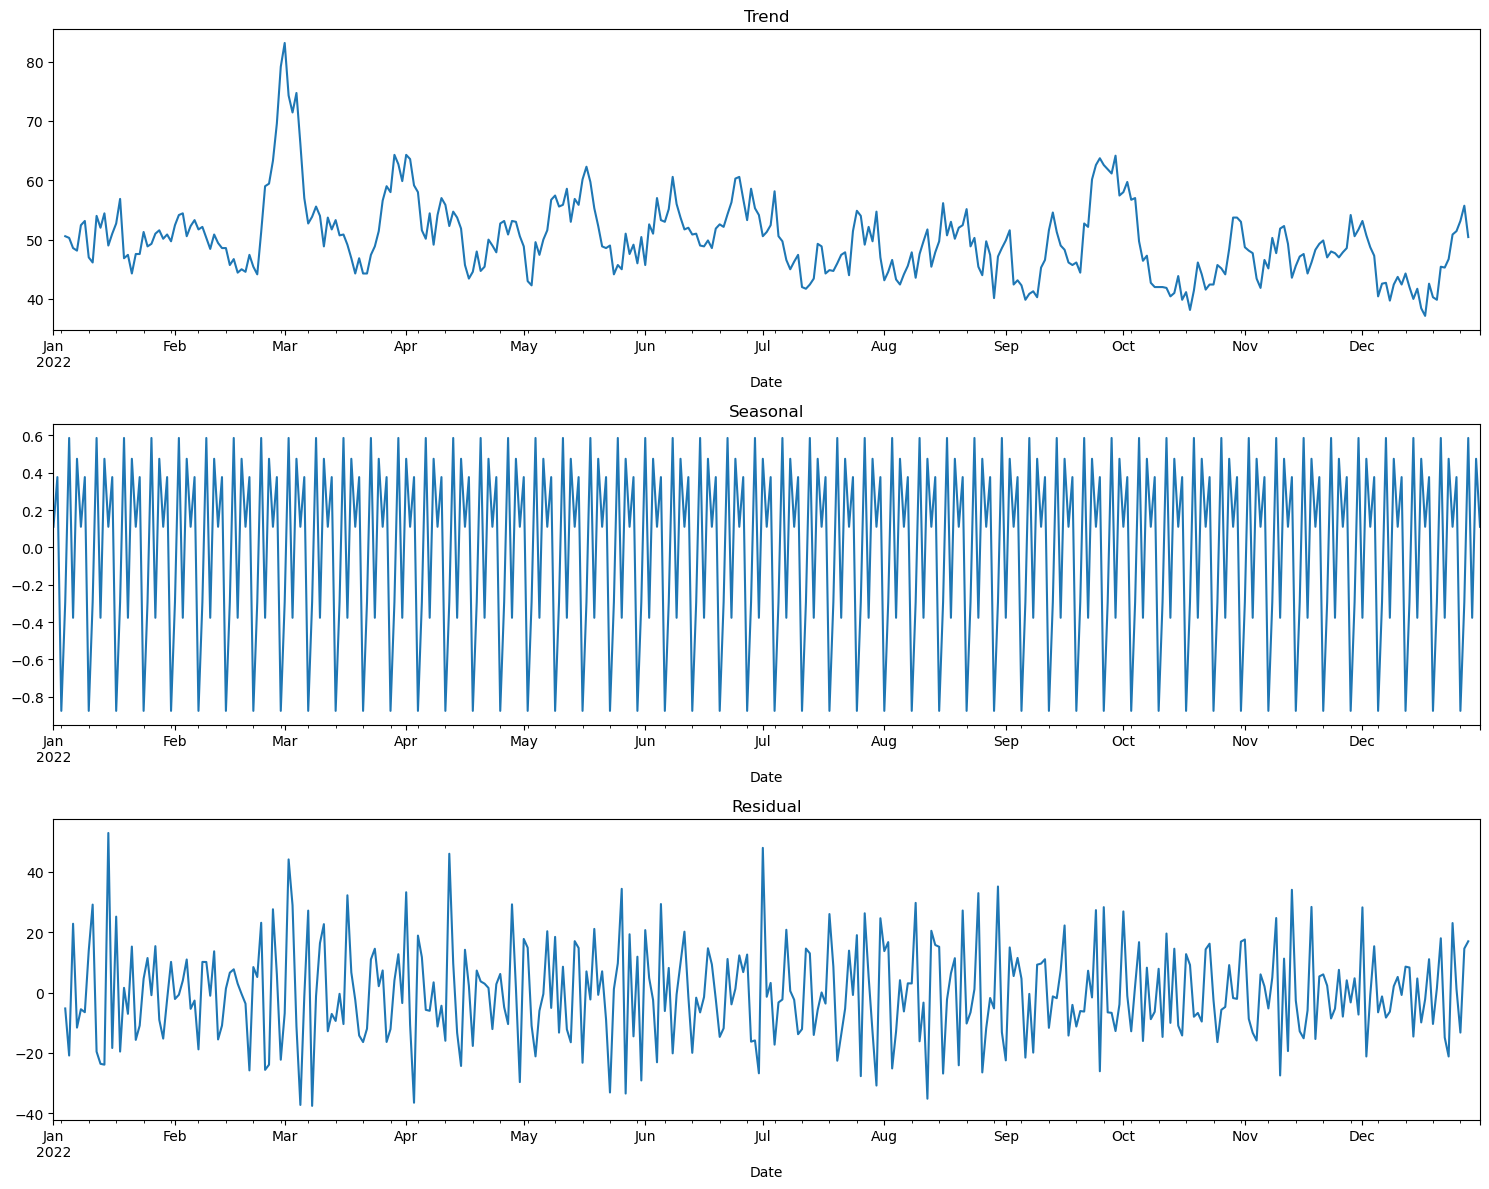

In [78]:
decompose = seasonal_decompose(df_pred)

fig,ax = plt.subplots(3,1,figsize=(15,12))
decompose.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decompose.seasonal.plot(ax=ax[1])
ax[1].set_title('Seasonal')
decompose.resid.plot(ax=ax[2])
ax[2].set_title('Residual')

plt.tight_layout()
plt.show()

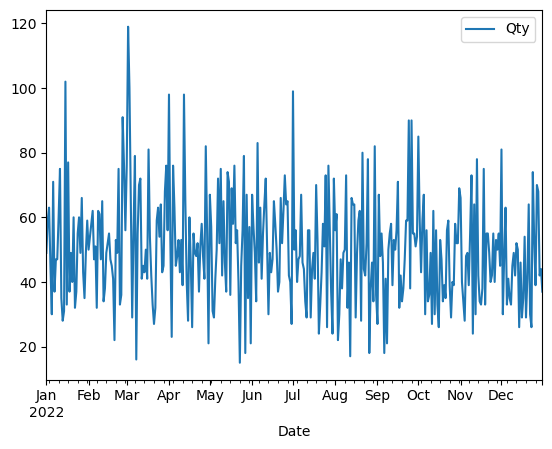

In [80]:
df_pred.plot()
plt.show()

# Transform Data

Melakukan tranformasi agar rentang nilai pada setiap kolom menjadi lebih dekat dan membuat model lebih mudah membaca dataset. Dan transformasi kali ini menggunakan logaritma

In [13]:
df_pred = np.log(df_pred)
df_pred.head(10)

,Qty
Date,
2022-01-01,3.891820
2022-01-02,4.077537
2022-01-03,4.143135
2022-01-04,3.806662
2022-01-05,3.401197
2022-01-06,4.262680
2022-01-07,3.610918
2022-01-08,3.850148
2022-01-09,3.850148


In [83]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Qty     365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


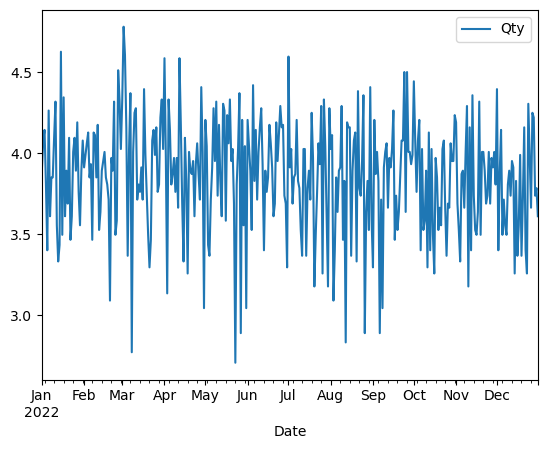

In [84]:
df_pred.plot()
plt.show()

# Check Data Stationary

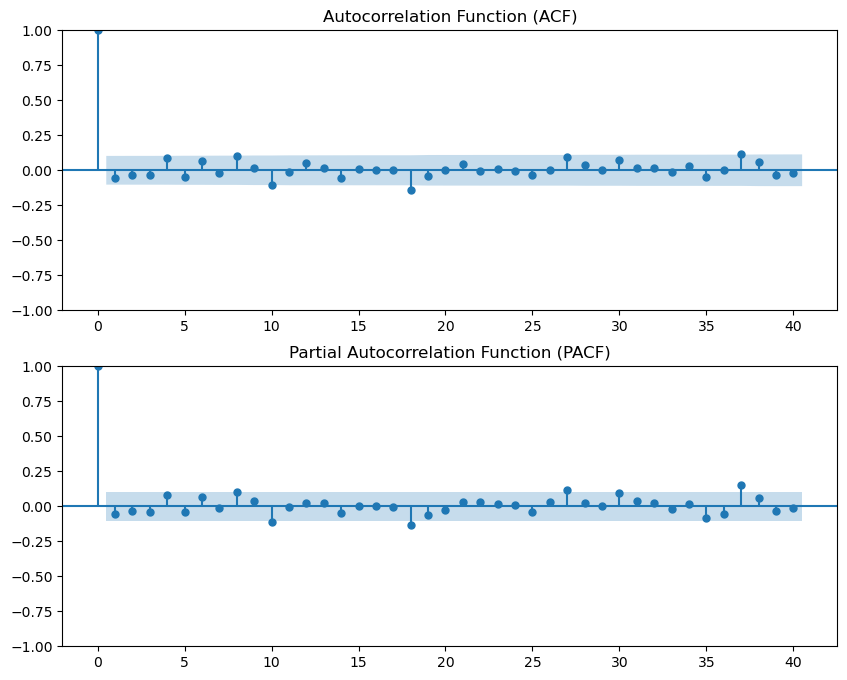

In [85]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ambil data 'Qty' dari DataFrame
data = df_pred['Qty']

# Plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(data, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(data, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()


Terlihat pada grafik bahwa pada step-2 ke atas pada ACF dan PACF berada dekat dengan 0.00 yang menandakan bahwa data stationary

# Modelling

Melakukan split data dengan rasio data train 80% dan data test 20%.

In [14]:
train, test = df_pred[:181], df_pred[181:]

#### Auto Parameter ARIMA

In [15]:
import pmdarima as pm
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 0, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

#### Manual Parameter

In [46]:
#Manual parameter tuning
def tune(z,y,x):
    model = ARIMA(train, order=(x,y,z))
    model_fit = model.fit()
    forecast_test = model_fit.forecast(len(test))
    df_plot = df[['Qty']].iloc[-364:]

    df_plot['forecast'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
    
    mae = mean_absolute_error(test, forecast_test)
    mape = mean_absolute_percentage_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    return mae,mape,rmse
    
#Parameter combinations
pval = list(range(1, 11,1))
dval = [0,1,2,3]
qval = [0,1,2,3]

comb = []
for i in pval:
    for j in dval:
        for k in qval:
            comb.append((i,j,k))

param = []
mae_score = []
mape_score = []
rmse_score = []

for i in comb:
    param.append(i)
    score = tune(*i)
    mae_score.append(score[0])
    mape_score.append(score[1])
    rmse_score.append(score[2])
    
tuning_df = pd.DataFrame({'param':param,'mae':mae_score,'mape':mape_score,'rsme':rmse_score})
tuning_df.sort_values(by='mae').head(3)

,param,mae,mape,rsme
91,"(6, 2, 3)",0.270423,0.073780,0.340954
105,"(7, 2, 1)",0.270725,0.073615,0.339833
139,"(9, 2, 3)",0.270866,0.074021,0.341509


Terlihat bahwa parameter dengan nilai error terkecil yaitu (6,2,3), jadi akan digunakan untuk modelling

In [17]:
model = ARIMA(train, order=(6, 2, 3))
model_fit = model.fit()


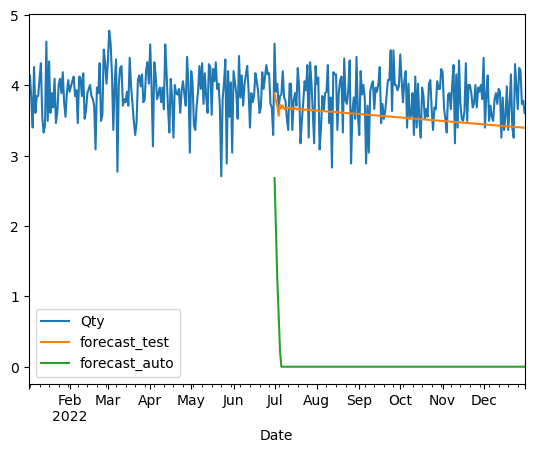

In [18]:
#plot forecasting
forecast_test = model_fit.forecast(len(test))
forecast_auto = auto_arima.predict(len(test))

df_plot = df_pred[['Qty']].iloc[-364:]

df_plot['forecast_test'] = [None]*(len(df_plot)-len(forecast_test)) + list(forecast_test)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

#### Manual Parameter Tuning Metrics

In [19]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 0.3638
mape - manual: 0.093
rmse - manual: 0.4351


#### Auto-fit ARIMA Metrics

In [20]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(test, forecast_auto)
mape = mean_absolute_percentage_error(test, forecast_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 3.7756
mape - auto: 0.991
rmse - auto: 3.7966


Dari grafik dan metric di atas bahwa grafik yang terlihat baik yaitu pada forcast_test dengan parameter secara manual dan dengan nilai error yang kecil pada parameter manual

# Prediction Overall Quantity

In [21]:
model = ARIMA(df_pred, order=(6, 2, 3))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

In [22]:
df_pred = np.exp(df_pred)
forecast = np.exp(forecast)

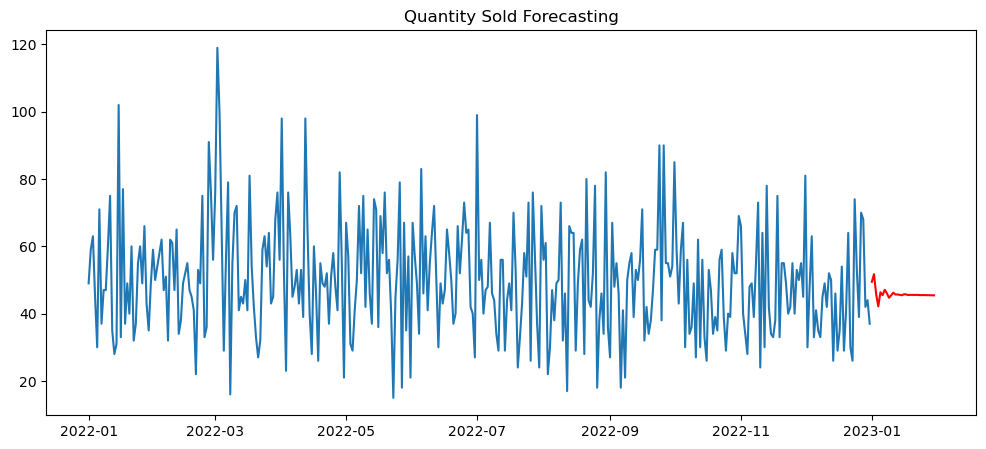

In [23]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_pred)
plt.plot(forecast,color='red')
plt.title('Quantity Sold Forecasting')
plt.show()

In [24]:
forecast.mean()

45.874673068574275

Dari prediksi di atas dapat disimpulkan bahwa untuk jumlah penjualan bulan depan adalah sekitar 45/46 pcs per harinya.

# Prediction Each Product

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
 12  StoreName       5020 non-null   object        
 13  GroupStore      5020 non-null   object        
 14  Type            5020 non-null   object        
 15  Lati

In [25]:
#Forecast for next 30 days for each product
list_prod = df['Product Name'].unique()

dfp = pd.DataFrame({'Date':pd.date_range(start='2023-01-01',end='2023-01-30')})
dfp = dfp.set_index('Date')
for i in list_prod:
    df_ = df[['Date','Product Name','Qty']]
    df_ = df_[df_['Product Name']==i]
    df_= df_.groupby('Date')[['Qty']].sum()
    df_ = df_.reset_index()

    df_t = pd.DataFrame({'Date':pd.date_range(start='2022-01-01',end='2022-12-31')})
    df_t = df_t.merge(df_,how='left',on='Date')
    df_t = df_t.fillna(0)
    df_t = df_t.set_index('Date')

    model1 = ARIMA(df_t, order=(6, 2, 3))
    model_fit1 = model1.fit()
    forecast1 = model_fit1.forecast(steps=30)
    dfp[i] = forecast1.values
    
dfp.head()

,Crackers,Yoghurt,Ginger Candy,Cheese Stick,Thai Tea,Choco Bar,Oat,Potato Chip,Coffee Candy,Cashew
Date,,,,,,,,,,
2023-01-01,4.396383,3.786231,8.295537,4.704317,3.465980,2.969204,2.337891,3.974457,6.329619,1.630553
2023-01-02,4.203956,4.774781,9.111722,5.592382,4.533690,4.502367,3.412253,3.300691,6.504222,1.721092
2023-01-03,4.588629,3.952522,5.741010,5.523987,3.686450,3.484007,2.882927,3.710620,6.368090,2.054387
2023-01-04,5.259858,4.570996,7.243712,5.502775,4.367934,4.486741,2.661517,3.628269,7.006572,1.661700
2023-01-05,4.267870,3.782476,7.084348,5.891586,4.800457,4.118404,3.280207,3.725290,8.727956,1.970972


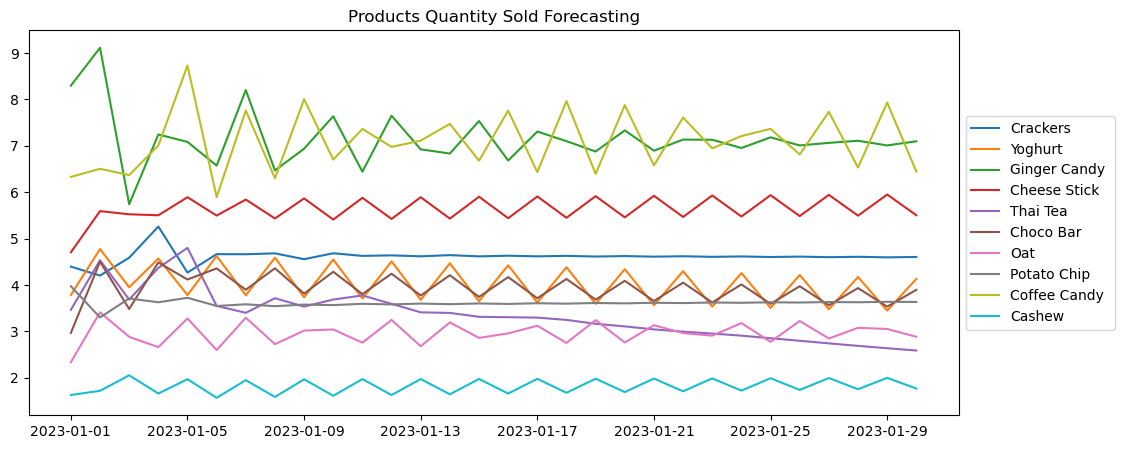

In [99]:
#Plot forecasting
plt.figure(figsize=(12,5))
# plt.plot(df_t)
plt.plot(dfp)
plt.legend(dfp.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Products Quantity Sold Forecasting')
plt.show()

In [26]:
#Products Quantity forecast
mean_values = dfp.describe().T['mean']
sorted_mean_values = mean_values.sort_values(ascending=False)

# Tampilkan nilai-nilai rata-rata dari yang terbesar
print(sorted_mean_values)

Ginger Candy    7.151435
Coffee Candy    7.092862
Cheese Stick    5.635549
Crackers        4.610294
Yoghurt         4.037937
Choco Bar       3.922810
Potato Chip     3.613439
Thai Tea        3.352608
Oat             2.962935
Cashew          1.819316
Name: mean, dtype: float64


Dari data prediction product di atas dapat dilihat perkiraan yang akan dibeli 3 terbanyak yaitu ada Ginger Candy, Coffee Candy, dan Cheese Stick

# Clustering Data Preparation

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
 12  StoreName       5020 non-null   object        
 13  GroupStore      5020 non-null   object        
 14  Type            5020 non-null   object        
 15  Lati

In [27]:
df_clust = df.groupby('CustomerID').agg({'TransactionID':'count','Qty':'sum','TotalAmount':'sum'})
df_clust_sorted = df_clust.nlargest(10, 'TotalAmount')
df_clust_sorted


,TransactionID,Qty,TotalAmount
CustomerID,,,
365,20,75,846700
89,19,79,760600
392,20,71,751400
184,14,64,676200
13,19,68,669000
72,16,65,667000
384,16,65,662200
166,13,66,644200
233,17,65,634700


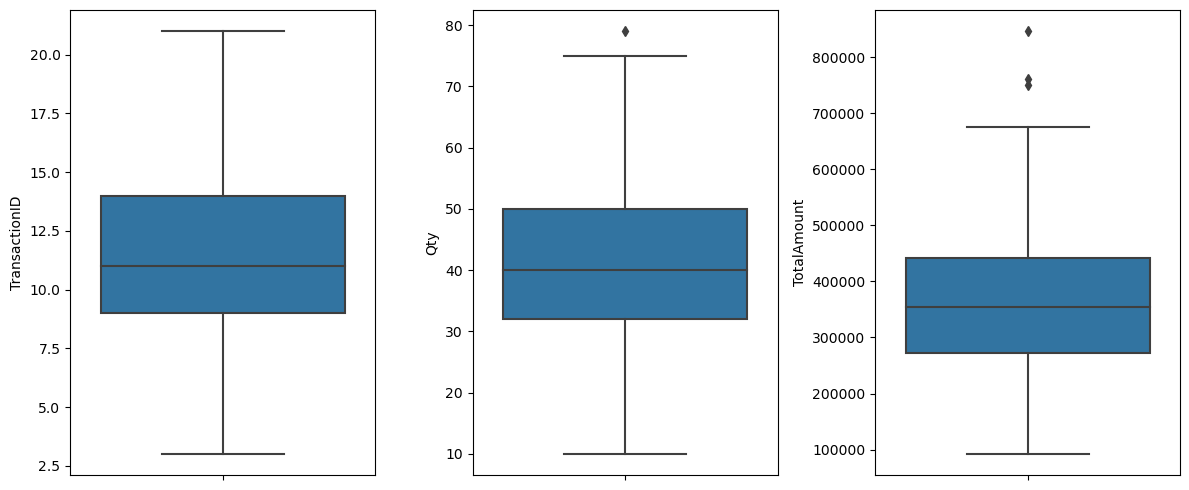

In [28]:
features = df_clust.columns
fig, ax = plt.subplots(1,len(df_clust.columns),figsize=(12,5))
for i in range(0,len(df_clust.columns)):
    sns.boxplot(data=df_clust,y=features[i],ax=ax[i])
plt.tight_layout()
plt.show()

Terlihat outliers tidak terlihat buruk, jadi tidak perlu melakukan cleansing outliers dan lanjut ke bagan selanjutnya

In [29]:
x = df_clust.values
x_std = StandardScaler().fit_transform(x)
df_std = pd.DataFrame(data=x_std,columns=df_clust.columns)
df_std.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

# Clustering Model

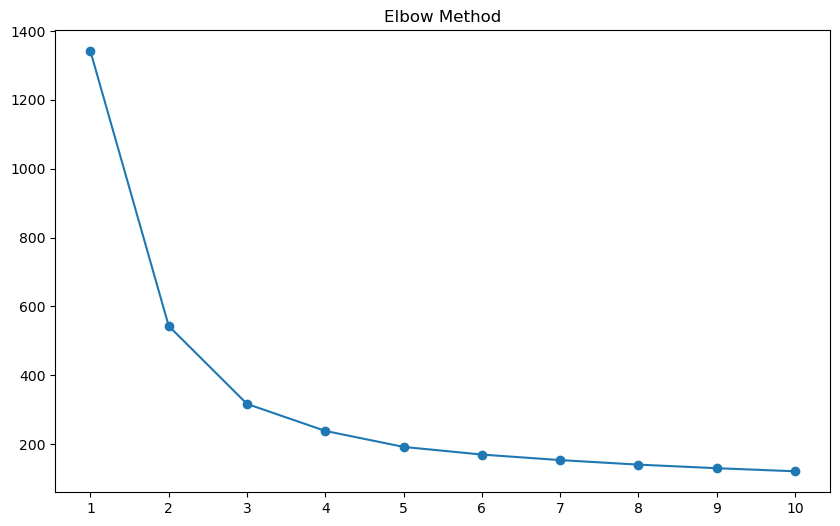

In [30]:
inertia = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df_std.values)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.xticks(list(range(1,11)))
plt.plot(range(1,11),inertia,marker='o')
plt.title('Elbow Method')
plt.show()

Pada Elbow Metthod menunjukkan cluster optimal pada n = 4

In [33]:
# Kmeans n_cluster = 4
#Clustering Kmeans
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=0)
kmeans_4.fit(x_std)

#Tambah clusters label pada dataset
df_cl4 = pd.DataFrame(data=x_std,columns=df_clust.columns)
df_cl4['cluster'] = kmeans_4.labels_
df_cl4.sample(5)

,TransactionID,Qty,TotalAmount,cluster
286,-0.688048,-0.779339,-0.320594,2
304,-0.379565,-0.386948,-0.698120,2
301,-0.996531,-0.857817,-0.469195,0
214,0.545884,0.397833,-0.001705,1
277,0.545884,0.554790,0.356543,1


<Figure size 400x400 with 0 Axes>

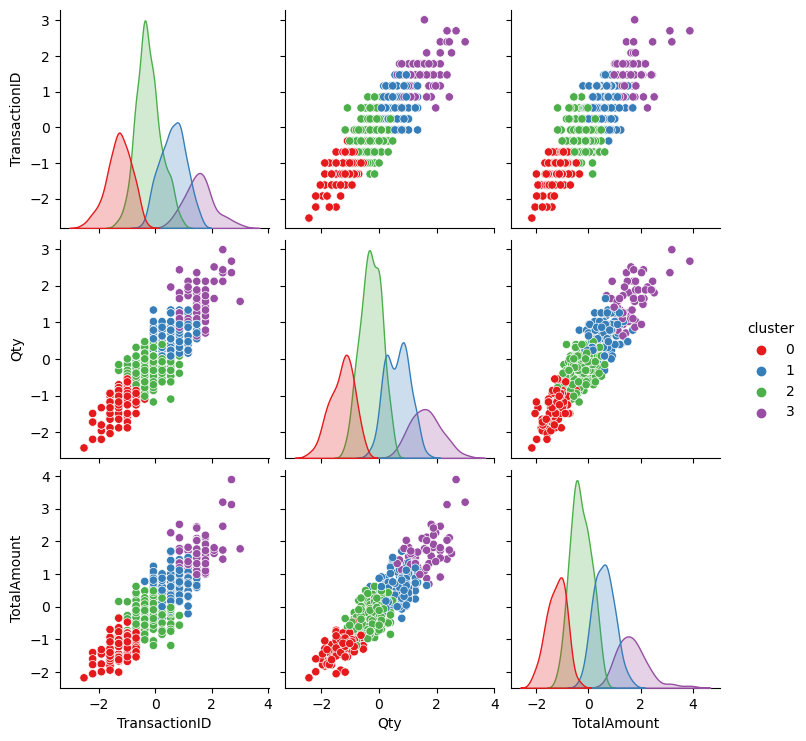

In [35]:
#PLot Before PCA
plt.figure(figsize=(4,4))
sns.pairplot(data=df_cl4,hue='cluster',palette='Set1')
plt.show()

In [38]:
#PCA
pcs_4 = PCA(n_components=2).fit_transform(x_std)
pdf_4 = pd.DataFrame(data=pcs_4,columns=['pc1','pc2'])
pdf_4['cluster'] = df_cl4['cluster']
pdf_4.describe().T

,count,mean,std,min,25%,50%,75%,max
pc1,447.000000,-0.000000,1.661646,-4.120551,-1.132975,-0.123870,1.081022,5.351262
pc2,447.000000,-0.000000,0.386276,-1.279946,-0.242372,-0.003848,0.246496,1.348982
cluster,447.000000,1.463087,0.967106,0.000000,1.000000,2.000000,2.000000,3.000000


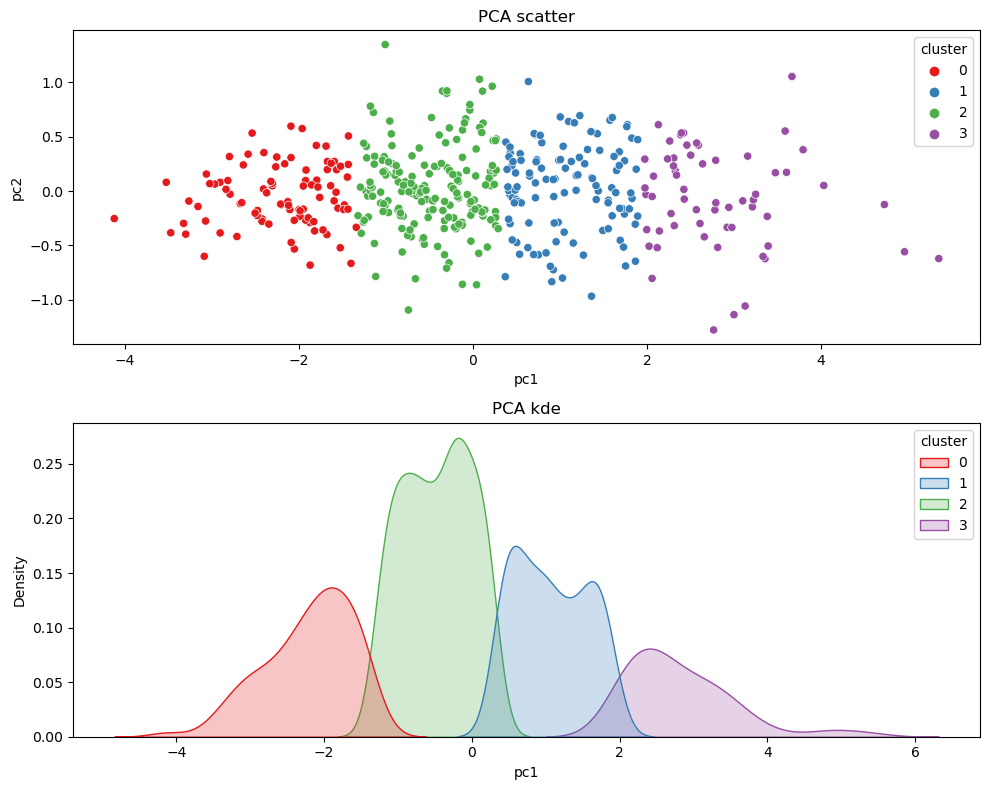

In [39]:
#PCA plot
fig,ax = plt.subplots(2,1,figsize=(10,8))
# plt.figure(figsize=(10,5))
sns.scatterplot(data=pdf_4,x='pc1',y='pc2',hue='cluster',palette='Set1',ax=ax[0])
ax[0].set_title('PCA scatter')
sns.kdeplot(data=pdf_4,x='pc1',hue='cluster',palette='Set1',fill=True,ax=ax[1])
ax[1].set_title('PCA kde')
plt.tight_layout()
plt.show()

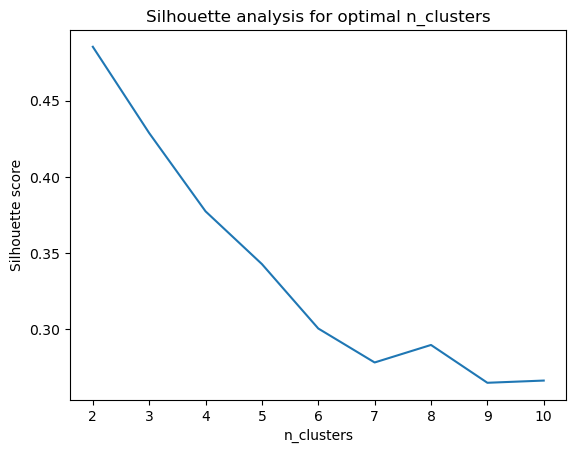

In [42]:
n_clust = list(range(2,11))
silhouette_avg = []
for i in n_clust:
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    
    labels = kmeans.fit_predict(x_std)
    silhouette_avg.append(silhouette_score(x_std,labels))
    
plt.plot(n_clust,silhouette_avg)
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for optimal n_clusters')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.48530485981509097
For n_clusters = 3 The average silhouette_score is : 0.4286478086768933
For n_clusters = 4 The average silhouette_score is : 0.3772419295085858
For n_clusters = 5 The average silhouette_score is : 0.34260947001461384
For n_clusters = 6 The average silhouette_score is : 0.30030062675665914
For n_clusters = 7 The average silhouette_score is : 0.2779945105823492
For n_clusters = 8 The average silhouette_score is : 0.28950107164370303
For n_clusters = 9 The average silhouette_score is : 0.26465882289666093
For n_clusters = 10 The average silhouette_score is : 0.2661140192818846


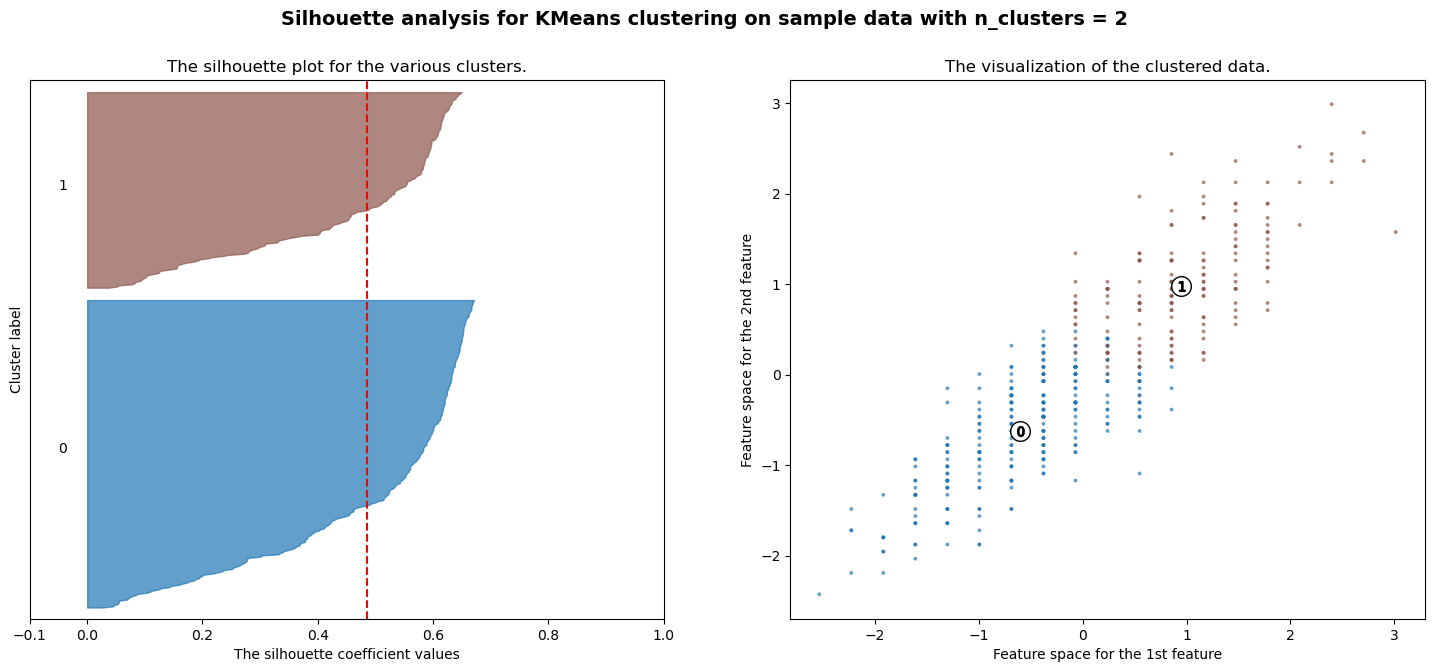

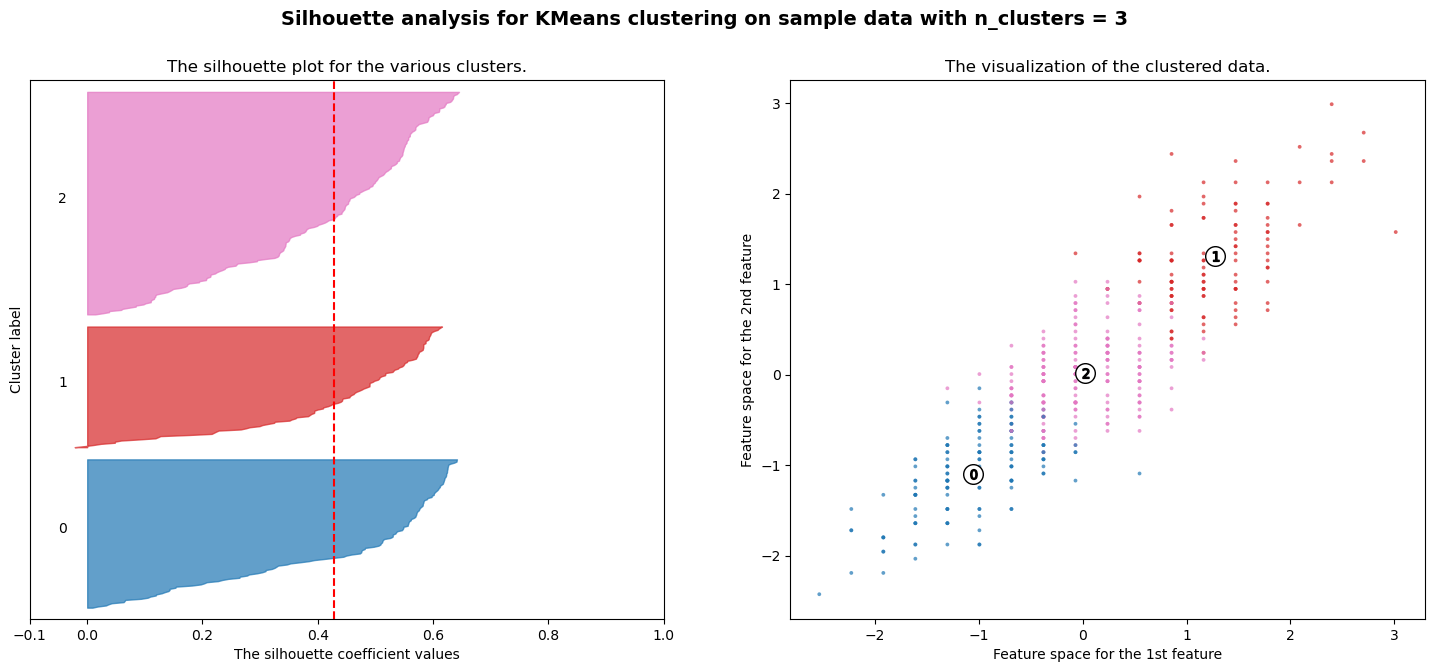

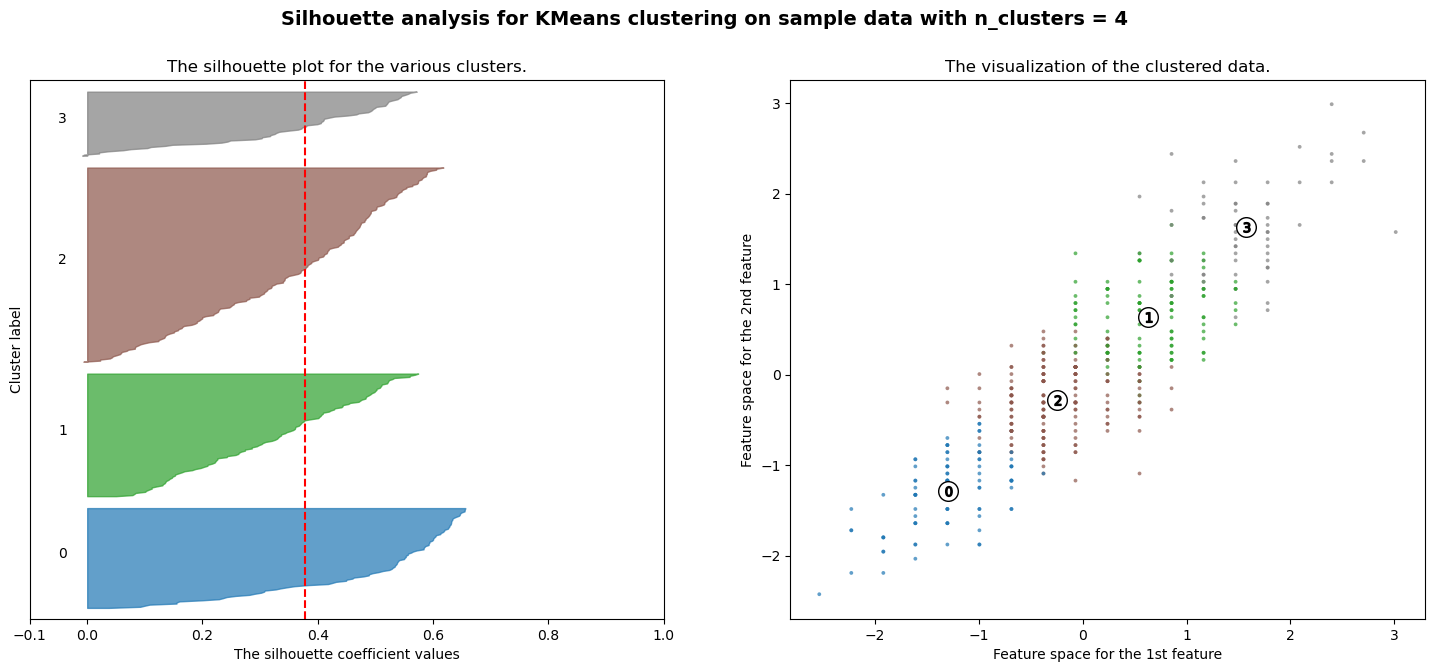

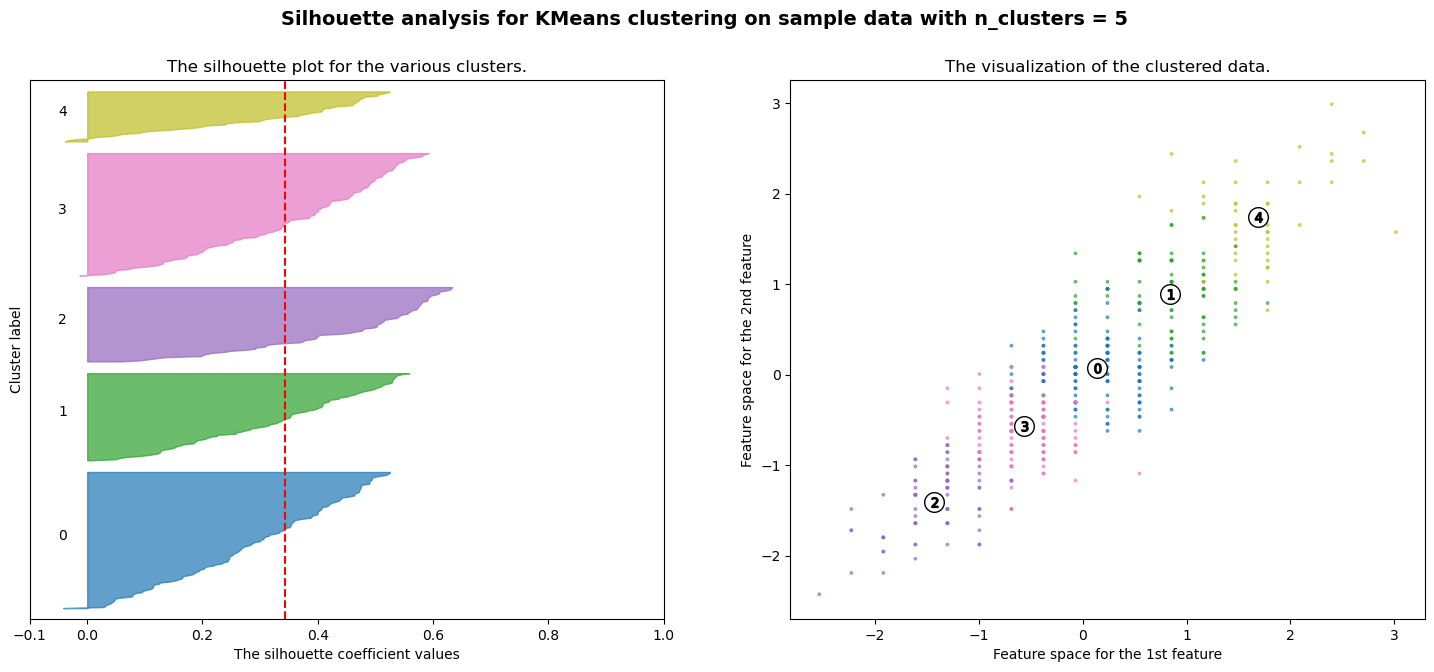

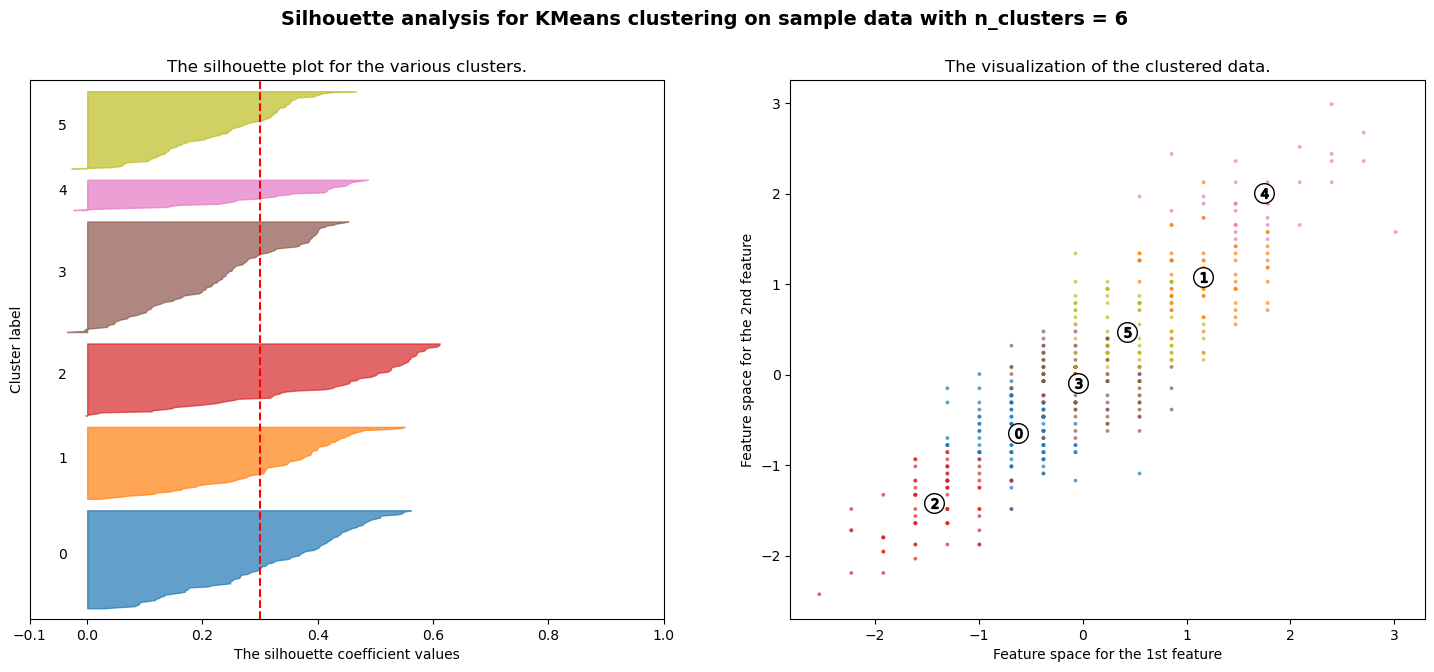

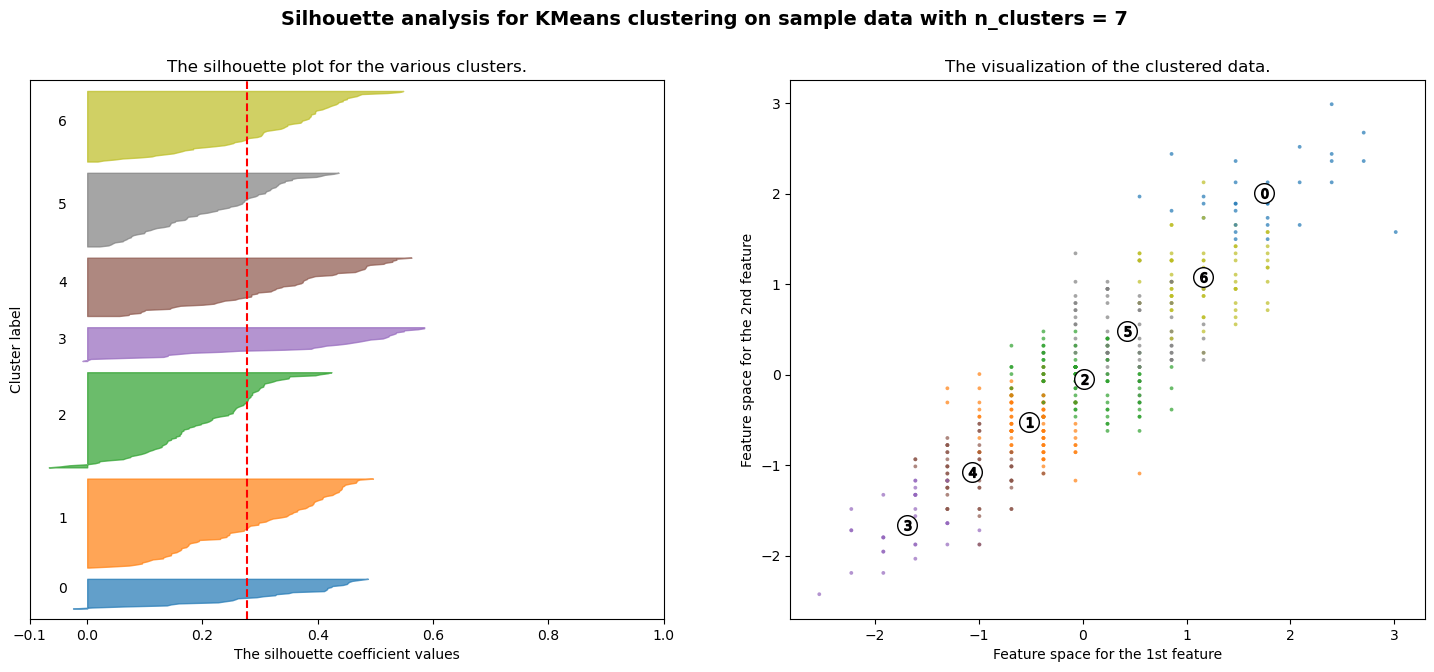

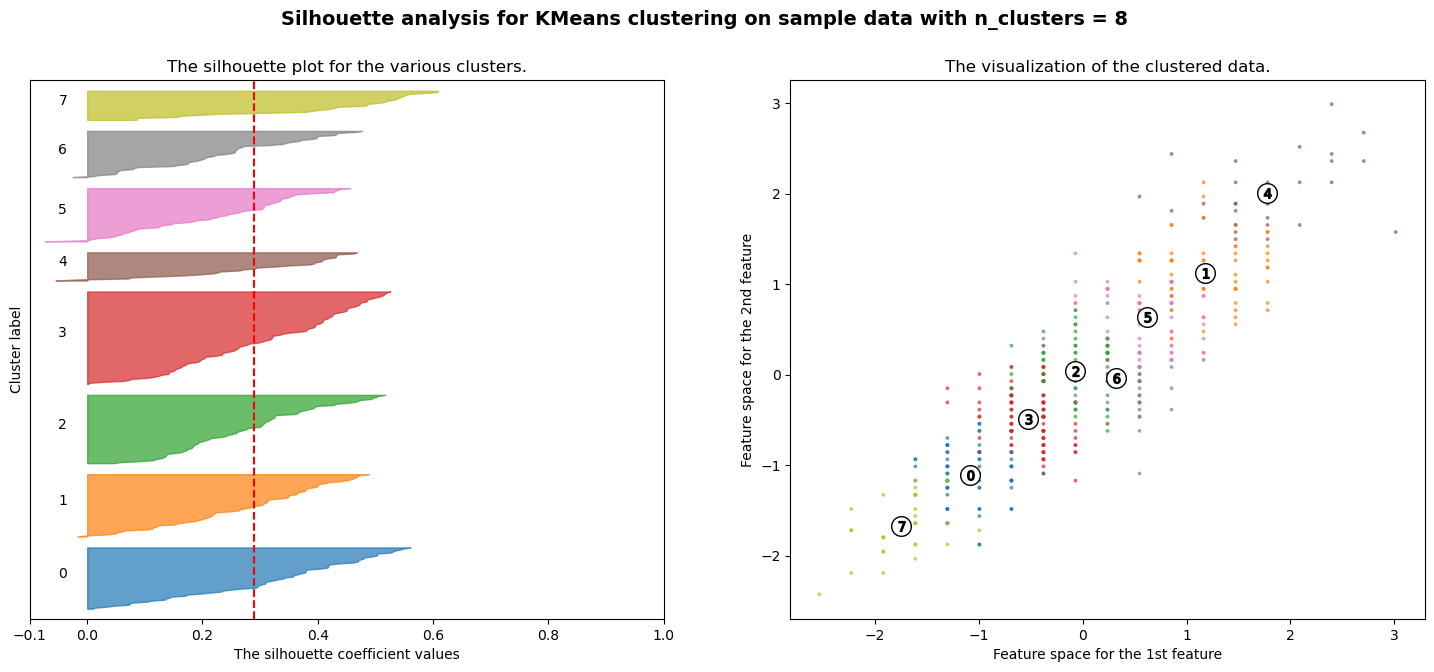

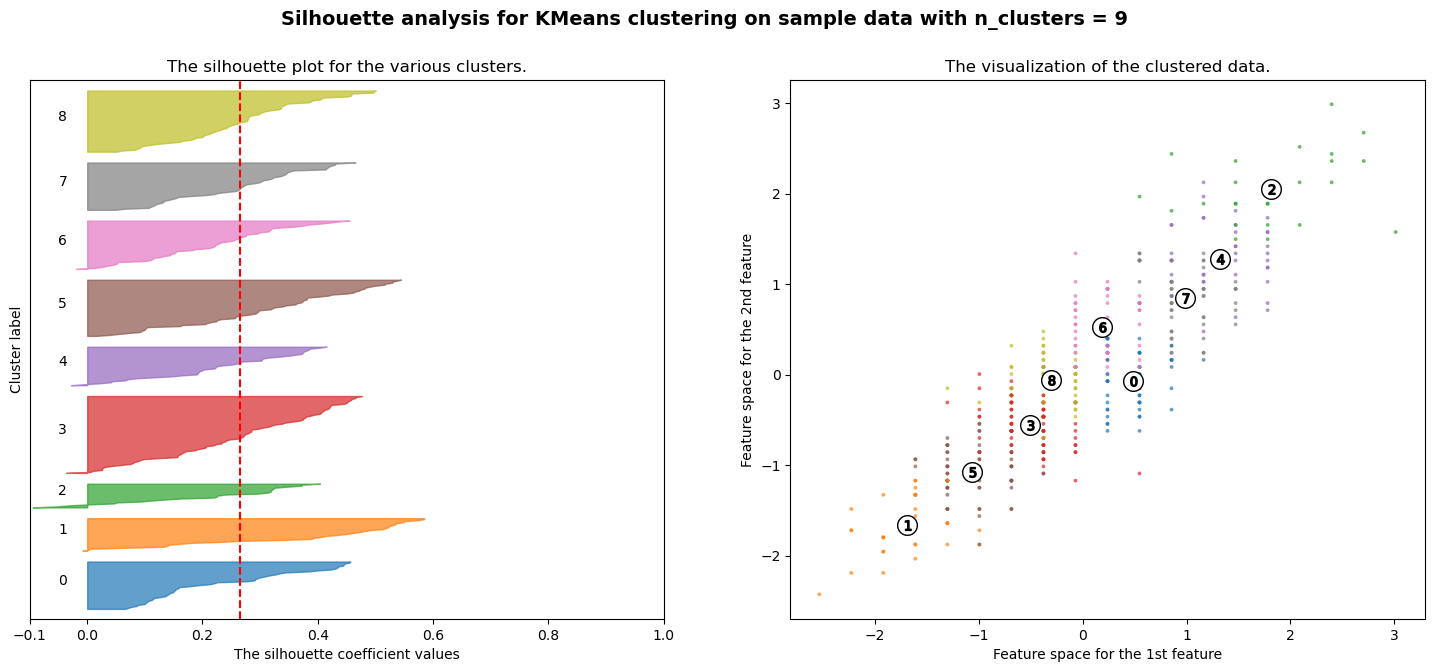

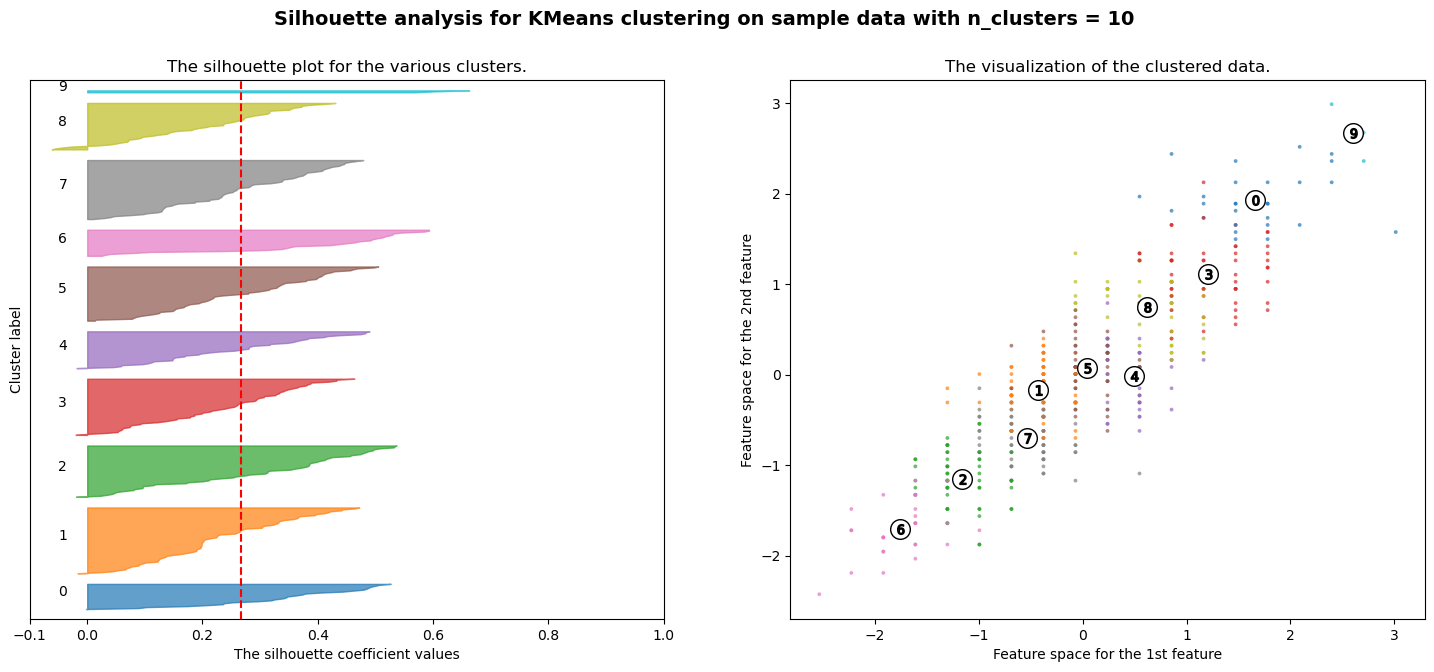

In [56]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
x = x_std
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = clusterer.fit_predict(x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.tab10(float(i) / n_clusters)  # Ubah bagian ini
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.tab10(cluster_labels.astype(float) / n_clusters)  # Ubah bagian ini
    ax2.scatter(
        x[:, 0], x[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Dari Silhouette Analyst, Silhouette score pada n = 4 terpisah dengan baik sebesar 0,377 

# Cluster Analysis (RFM Analysis)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
 12  StoreName       5020 non-null   object        
 13  GroupStore      5020 non-null   object        
 14  Type            5020 non-null   object        
 15  Lati

In [59]:
df_clust['cluster'] = kmeans_4.labels_

df['recency'] = (pd.to_datetime('2023-01-01') - df_['Date']).dt.days.astype('int')
df_r = df.groupby('CustomerID').agg({'recency':'min'})

df_rfm = df_clust.copy()
df_rfm['recency'] = df_r['recency']

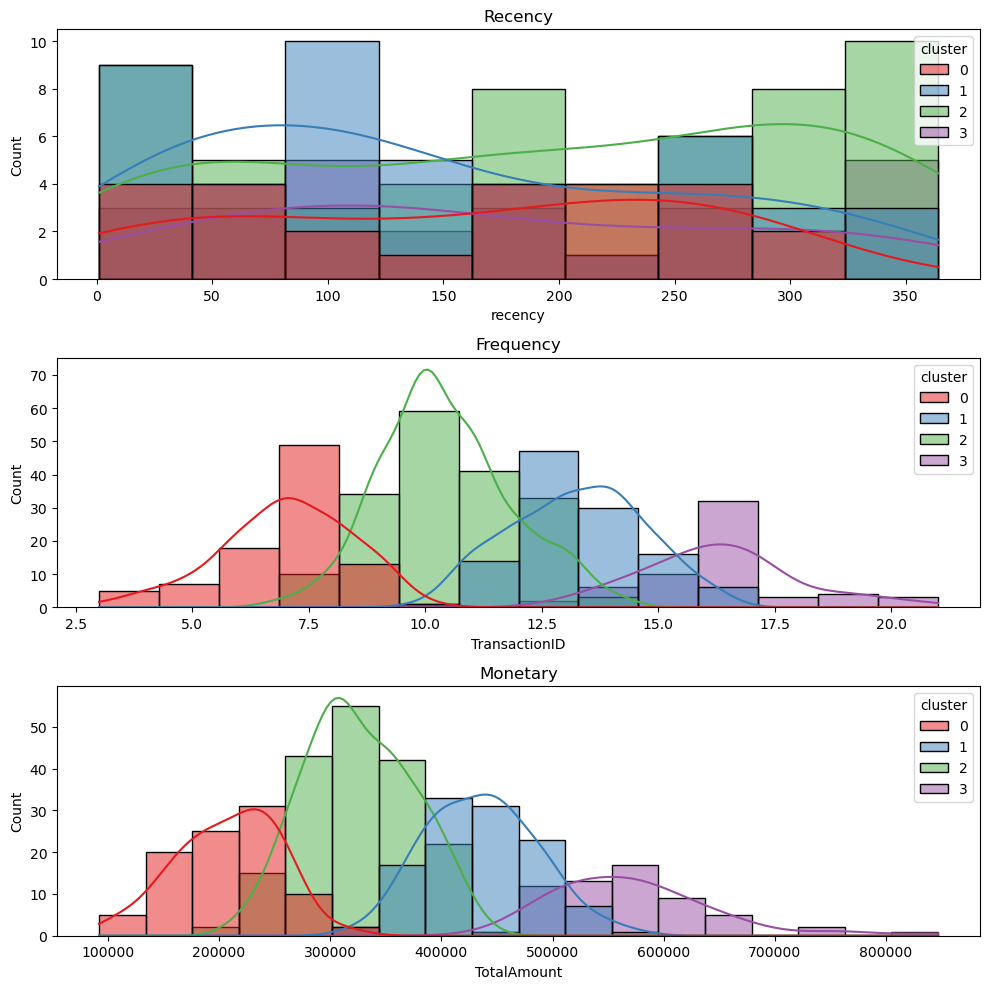

In [62]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
sns.histplot(data=df_rfm,x='recency',hue='cluster',palette='Set1',ax=ax[0],kde=True)
ax[0].set_title('Recency')
sns.histplot(data=df_rfm,x='TransactionID',hue='cluster',palette='Set1',ax=ax[1],kde=True)
ax[1].set_title('Frequency')
sns.histplot(data=df_rfm,x='TotalAmount',hue='cluster',palette='Set1',ax=ax[2],kde=True)
ax[2].set_title('Monetary')

plt.tight_layout()
plt.show()

Karkteristik klaster pelanggan :
- Cluster 0 (Pelanggan Baru):
    - Memiliki recency yang rendah dan agak tinggi dengan jumlah customer yang tidak banyak
    - Memiliki Frequency dan Monetary terendah
    - Strategi:
        - Memberikan Responsivitas dan interaksi yang baik untuk memberikan kesan positif
        - Diskon transaksi pertama di beberapa jenis produk
        - Meminta preferensi dan minat yang dibutuhkan mereka dan dihubungkan dengan produk yang ada
        - Meminta umpan balik tentang pengalaman bertransaksi untuk memahami dan meningkatkan kualitas layanan


- Cluster 1 (Pelanggan Potensial):
    - Memiliki Recency dari yang rendah dengan jumlah customer yang banyak hingga yang tinggi dengan jumlah customer yang sedikit
    - Memiliki frekuensi pembelian yang agak tinggi dengan jumlah customer yang cukup banyak
    - Memiliki Monetary yang agak tinggi dengan jumlah total yang cukup banyak
    - Strategi:
        - Analisa data dan informasi yang dimiliki untuk memahami preferensi dan kebutuhan customer
        - Memberikan diskon atau kupon saat melakukan pembelian produk yang total harga banyak


- Cluster 2 (Pelanggan Aktif):
    - Memiliki Recency yang standar hingga tinggi dengan jumlah customer yang banyak dan recency yang rendah dengan jumlah customer yang cukup
    - Memiliki Frekuensi yang cukup dengan jumlah customer yang paling banyak
    - Memiliki Monetary yang cukup dengan jumlah customer yang paling banyak
    - Strategi:
        - Memberikan informasi mengenai pembaruan dan perkembangan produk atau inovasi terbaru pada bisnis
        - Memberikan diskon atau kupon saat melakukan beberapa kali pembelian
        - Minta umpan balik dari customer tentang pengalaman bertransaksi agar mereka berasa lebih dihargai


- Cluster 3 (Pelanggan Setia)
    - Memiliki Recency yang rendah dengan jumlah customer yang tidak banyak
    - Memiliki Frekuensi yang paling tinggi dengan jumlah customer yang cukup
    - Memiliki Monetary yang paling tinggi dengan jumlah customer yang paling sedikit
    - Strategi :
        - Memberikan pesan atau hadiah spesial kepada pelanggan setia di saat hari ulang tahun.
        - Membuat promo kejutan atau diskon tak terduga agar customer yang setia merasa lebih dihargai
        - Memberikan pelayanan yang unggul 
        - Memberikan informasi mengenai pembaruan dan perkembangan produk atau inovasi terbaru pada bisnis